In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pywt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
_IMG_PATH = '../images/lena512.bmp'

In [3]:
img = cv2.imread(_IMG_PATH)
img.shape

(512, 512, 3)

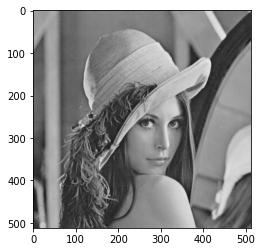

In [4]:
plt.imshow(img)

In [5]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img_gray

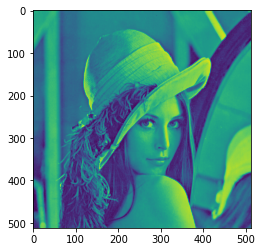

In [6]:
plt.imshow(img_gray)

In [7]:
def add_noisy(img, var=None):
    """
    create a noise array with the same size as the input image
    add noise array into the input image
    """
    row,col= img.shape
    mean = 0
    if not var:
        var = 25
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = img + gauss
    return noisy, gauss

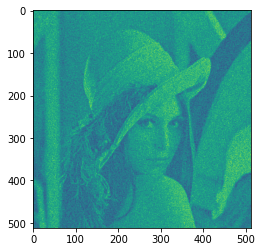

In [8]:
img_noise, noise = add_noisy(img_gray, var=50**2)
plt.imshow(img_noise)

In [9]:
def transform_wavelet(spatial):
    coeffs2 = pywt.dwt2(spatial, 'db2')
    return coeffs2

In [10]:
y_coeffs = transform_wavelet(img_noise)
x_coeffs = transform_wavelet(img_gray)
v_coeffs = transform_wavelet(noise)

## Local PCA

In [11]:
def divide_patches(I, patch_size = (7,7)):
    """
    I is the image function
    """
    patches_array = np.lib.stride_tricks.sliding_window_view(I, (7,7))
    patches_array_rot = np.moveaxis(patches_array, 0, 1)
    training_region = patches_array_rot.reshape(
                                (patches_array_rot.shape[0]*patches_array_rot.shape[1],
                                 patches_array_rot.shape[2]*patches_array_rot.shape[3]))
    return training_region

In [12]:
hyper_params = {}
hyper_params['patch_size'] = 7
hyper_params['train_region_size'] = 20
hyper_params['n_components'] = 250

In [13]:
def define_centroid_patches(hyper_params, I):
    """
    I is the image function
    """
    ## define size of mask follow size of feature map
    ## mask is the array of centroids of patches
    centroids_width = I.shape[0] - hyper_params['patch_size'] + 1
    centroids_height = I.shape[1] - hyper_params['patch_size'] + 1
    total_num_centroids = centroids_width*centroids_height
    
    ## define index matrix of the centroids array
    centroids_map_index = np.arange(total_num_centroids)
    centroids_map_index = centroids_map_index.reshape((centroids_height, centroids_width)).T
    
    return centroids_map_index, centroids_width, centroids_height

In [14]:
def get_principal_components(centroids_map_index, 
                      training_region, 
                      current_row, 
                      current_col,
                      current_centroid_idx,
                      hyper_params):
    
    [centroids_width, centroids_height] = centroids_map_index.shape

    rmin = max(current_row - hyper_params['train_region_size'], 0)
    rmax = min(current_row + hyper_params['train_region_size'] + 1, centroids_width)
    cmin = max(current_col - hyper_params['train_region_size'], 0)
    cmax = min(current_col + hyper_params['train_region_size'] + 1, centroids_height)

    idx = centroids_map_index[rmin: rmax, cmin: cmax]
    idx = (idx.T).flatten()
    
    ## training_region has size of 506*506*7*7
    ## training_set has size 21*21*7*7
    training_set = training_region[idx,:]
    
    ## denoise_region is signal with noise in middle 7*7
    denoise_region = training_region[current_centroid_idx,:]
    
    ## calculate distance to selecting principal components
    init_distance = (training_set[:, 0] - denoise_region[0])**2
    init_distance = init_distance.reshape((init_distance.shape[0], 1))

    for k in range(1, training_region.shape[1]):
        partial_distance = (training_set[:, k] - denoise_region[k])**2
        partial_distance = partial_distance.reshape((partial_distance.shape[0], 1))
        init_distance += partial_distance

    components_distance = init_distance/training_region.shape[1]
    components_distance_sort = np.argsort(components_distance, axis=0)
    
    pc_index = idx[components_distance_sort[0:hyper_params['n_components']]]

    return pc_index

In [15]:
def pca_transform(X):
    # %X: MxN matrix (M dimensions, N trials)
    # %Y: Y=P*X
    # %P: the transform matrix
    # %V: the variance vector

    [M, N] = X.shape

    mx = (np.mean(X, axis=1)).reshape((M, 1))

    X = X - mx

    CovX = np.matmul(X,X.T) / (N-1)
    
    [V, P]= np.linalg.eig(CovX)

    V_minus = -1 * V
    ind = np.argsort(V_minus, axis=0)

    V = V[ind];
    P = P[:, ind]

    P = P.T
    Y = np.matmul(P, X)

    return [Y, P, V, mx]

In [16]:
var_noise_est = np.median(np.abs(y_coeffs[-1][-1]))/0.6745
var_noise_est

49.9200345703105

In [17]:
centroids_map_index, centroids_width, centroids_height = define_centroid_patches(hyper_params, img_noise)
training_region = divide_patches(img_noise)

In [18]:
training_region.shape

(256036, 49)

In [19]:
Y = np.zeros(training_region.T.shape)
for i in tqdm(range(centroids_width)):
    for j in range(centroids_height):
        
        current_row = i
        current_col = j

        current_centroid_idx = current_col*centroids_width + current_row

        pc_idx = get_principal_components(centroids_map_index, 
                      training_region, 
                      current_row, 
                      current_col,
                      current_centroid_idx,
                      hyper_params)
        
        pc_idx = pc_idx.flatten()
        
        [coe, P, V, mX] = pca_transform(training_region.T[:, pc_idx])
        
        py = np.mean(coe**2, axis=1)
        py = py.reshape((py.shape[0], 1))
        px = np.maximum(np.zeros(py.shape), py - var_noise_est**2)

        wei = px/py
        partial = ((coe[:, 0]).T * (wei.T)).T
        partial2 = np.matmul(P.T, partial)
        partial3 = mX[:, 0]
        partial3 = partial3.reshape((partial3.shape[0], 1))

        Y[:, current_centroid_idx] = (partial2 + partial3)[:, 0]

100%|██████████| 506/506 [09:58<00:00,  1.18s/it]


In [51]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

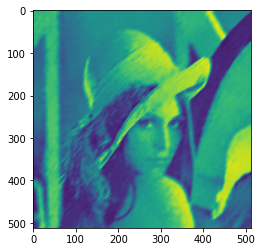

In [72]:
YT = Y.T
YT_reshape = YT.reshape(YT.shape[0],int(np.sqrt(YT.shape[1])),int(np.sqrt(YT.shape[1])))
img_reconstruct = reconstruct_from_patches_2d(YT_reshape, (512,512))
img_denoise = np.rot90(np.fliplr(img_reconstruct))
plt.imshow(img_denoise)

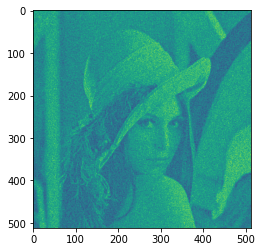

In [33]:
plt.imshow(img_noise)

In [42]:
def PSNR(img_origin, img_denoise):
    mse = np.mean((img_origin - img_denoise) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [73]:
PSNR(img_gray, img_denoise)

25.771841164416358

In [74]:
PSNR(img_gray, img_noise)

14.163941538340206